In [11]:
from utils import *

# Bandwith (BW) vs Slope Estimation

In [12]:
directory_path = './Data/fig12-bw'
data_dict = read_data_dict(directory_path)

print(len(data_dict))

75


In [13]:
# Tag delay line parameters

delta_L1 = (72 - 3) * 0.0254
delta_L2 = (72 - 48) * 0.0254
delta_L3 = (48 - 3) * 0.0254
d = 0.1
speed_ratio = 0.7453

In [14]:
expected_ratios = [
    delta_L1 / delta_L3,  # Ratio 1 (L1 to L3)
    delta_L3 / delta_L2,   # Ratio 2 (L3 to L2)
    delta_L1 / delta_L2,   # Ratio 2 (L3 to L2)
]
tolerance = 0.6  # Tolerance for ratio matching

In [15]:
angle_w_slope = {}
slope_w_angle = {}
predicted_slopes = []
predicted_angles = []
gt_slopes = []
gt_angles = []

angle_w_bandwidth = {}
slope_w_bandwidth = {}

file_count = 0
for key in data_dict:
    data_obj = data_dict[key]
    theory_peak_1, theory_peak_2, theory_peak_3 = calculate_gt_frequency_peak(data_obj, delta_L1, delta_L2, delta_L3, d, c, speed_ratio)
    gt_peaks = theory_peak_1, theory_peak_2, theory_peak_3
    data = data_obj['data']
    gt_slope = data_obj['slope']
    gt_angle = data_obj['angle']
    gt_bw = data_obj['bw']
    file_count += 1
    timestamp = data[:, 0]
    amplitude = data[:, 1] * 1.0
    fs = len(timestamp) / ((timestamp[-1] - timestamp[0])) # timestamps in 1us
    _, _, valid_freq_list = find_beat_freq_triplet_with_expected_ratio(expected_ratios, tolerance, data_obj, radar_detection_mode = False, small_peak_cal = 100, plot = False, return_snr = False, crop_to_list = True, noise_count = 10, noise_level = 8, window_length = 15)
    for predicted_peaks in valid_freq_list:
        if len(predicted_peaks) == 0:
            continue
        predicted_slope, predicted_angle = calculate_slope_and_angle(predicted_peaks, delta_L1, delta_L2, delta_L3, d, c, speed_ratio, frequency_offsets = [0, 1300, 0])
        predicted_slopes.append(predicted_slope)
        predicted_angles.append(predicted_angle)
        gt_slopes.append(gt_slope)
        gt_angles.append(gt_angle)
        
        if gt_bw not in angle_w_bandwidth:
            angle_w_bandwidth[gt_bw] = {}
        if gt_angle not in angle_w_bandwidth[gt_bw]:
            angle_w_bandwidth[gt_bw][gt_angle] = []
        angle_w_bandwidth[gt_bw][gt_angle].append(predicted_angle)
        
        
        if gt_bw not in slope_w_bandwidth:
            slope_w_bandwidth[gt_bw] = {}
        if gt_slope not in slope_w_bandwidth[gt_bw]:
            slope_w_bandwidth[gt_bw][gt_slope] = []
        percentage_error = (np.abs(predicted_slope - gt_slope) / gt_slope) * 100
        slope_w_bandwidth[gt_bw][gt_slope].append(percentage_error)

c:\Users\Daniel\Desktop\hidden-radar-detection\release\utils.py:851: RuntimeWarning: invalid value encountered in arcsin
  predicted_angle = np.rad2deg(np.arcsin(((predicted_peak2 * c) / predicted_slope - (delta_L2 / speed_ratio)) / (2*d)))


In [16]:
per_bw_slope_error = {}
for bw in slope_w_bandwidth:
    # if bw != 500000000:
    #     continue
    if bw not in per_bw_slope_error:
        per_bw_slope_error[bw] = {}
    for slope in slope_w_bandwidth[bw]:
        errors = []
        for slope_error in slope_w_bandwidth[bw][slope]:
            error = slope_error
            errors.append(error)
        if slope not in per_bw_slope_error[bw]:
            per_bw_slope_error[bw][slope] = errors
        print(len(errors))
print(per_bw_slope_error)

84
91
105
{1000000000.0: {3333333333333.3335: [5.454753225735132, 2.255729197127226, 3.4539502113761134, 4.120884549495791, 4.358267957979067, 5.92952004270167, 6.8112298456395255, 6.551238493491181, 4.753906972117852, 3.374822408548374, 4.923466549605894, 6.087775648357177, 5.522577056730336, 5.658224718720776, 4.934770521438427, 4.053060718500556, 5.217369817251841, 2.6174562957684078, 3.668725676194336, 4.844338746778139, 4.595651366462329, 4.923466549605894, 6.132991535687329, 6.223423310347617, 6.94687750762998, 4.5730434227972605, 3.7139415635244726, 3.917413056510117, 6.17820742301748, 7.444252268261586, 5.16084995808917, 4.301748098816382, 7.998146888055893, 3.126135028232549, 5.997343873696889, 5.590400887725571, 3.9287170283426662, 5.093026127093935, 1.75835443649562, 3.0243992817397114, 3.0130953099071776, 3.171350915562685, 2.131385506969321, 1.6114028026726464, 5.793872380711231, 26.4676632293486, 3.6009018451990866, 4.765210943950385, 4.855642718610688, 3.8948051128450483

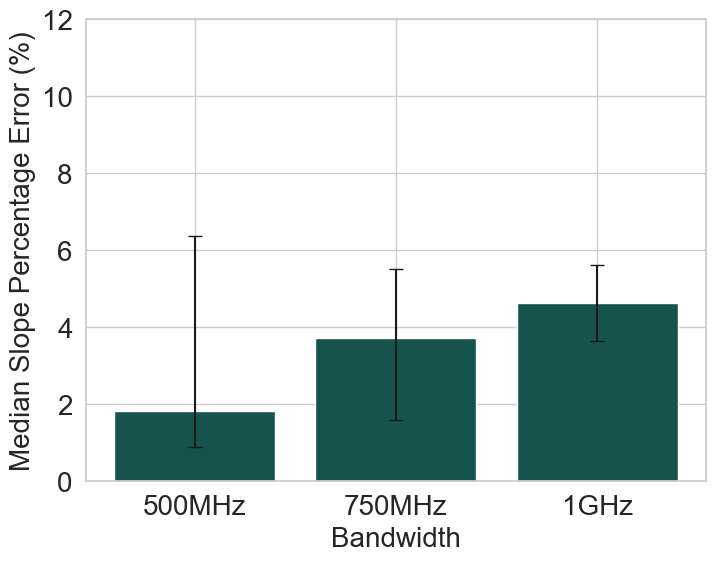

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.ticker import FuncFormatter
import json


color_map = sns.color_palette("cubehelix", 3).as_hex()

hatch_map = ['', '/', '//']

# Set seaborn style
sns.set(style="whitegrid")

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fontsize = 20

# Initialize lists to hold the data and labels
data = []
x_labels = []

# Sort slopes
sorted_slopes = sorted(per_bw_slope_error.keys())
bandwidth = ['500MHz', '750MHz', '1GHz']


# Collect errors and labels in sorted order
for index, slope in enumerate(sorted_slopes):
    all_errors = []
    angle_dict = per_bw_slope_error[slope]
    for angle, errors in angle_dict.items():
        errors = np.array(errors)
        # Filter out NaN values and collect all errors
        all_errors.extend(errors[~np.isnan(errors)])
    data.append(all_errors)
    x_labels.append(bandwidth[index])
    

# Calculate median, Q1, and Q3 for each slope
medians = [np.median(errors) for errors in data]
q1 = [np.percentile(errors, 25) for errors in data]
q3 = [np.percentile(errors, 75) for errors in data]

# Calculate the interquartile range for the error bars
iqr_error = [np.subtract(medians, q1), np.subtract(q3, medians)]


# Plot the median values with error bars showing the Q1 and Q3 range
plt.figure(figsize=(8, 6))
plt.bar(range(len(medians)), medians, yerr=iqr_error, capsize=5, align='center', color=color_map[0], hatch=hatch_map[0])
plt.xticks(range(len(medians)), x_labels, fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Bandwidth', fontsize = fontsize)
plt.ylabel('Median Slope Percentage Error (%)', fontsize = fontsize)
plt.ylim(0, 12)
plt.grid(True)
plt.show()

# Chirp Duration (CD) vs Slope Estimation

In [24]:
directory_path = './Data/fig12-cd'
data_dict = read_data_dict(directory_path)

In [25]:
angle_w_slope = {}
slope_w_angle = {}
predicted_slopes = []
predicted_angles = []
gt_slopes = []
gt_angles = []

angle_w_bandwidth = {}
slope_w_bandwidth = {}

file_count = 0
for key in data_dict:
    data_obj = data_dict[key]
    theory_peak_1, theory_peak_2, theory_peak_3 = calculate_gt_frequency_peak(data_obj, delta_L1, delta_L2, delta_L3, d, c, speed_ratio)
    gt_peaks = theory_peak_1, theory_peak_2, theory_peak_3
    data = data_obj['data']
    gt_slope = data_obj['slope']
    gt_angle = data_obj['angle']
    gt_bw = data_obj['bw']
    file_count += 1
    timestamp = data[:, 0]
    amplitude = data[:, 1] * 1.0
    fs = len(timestamp) / ((timestamp[-1] - timestamp[0])) # timestamps in 1us
    _, _, valid_freq_list = find_beat_freq_triplet_with_expected_ratio(expected_ratios, tolerance, data_obj, radar_detection_mode = False, plot = False, fix_amplitude_order = True, return_snr = False, crop_to_list = True, noise_count = 10, noise_level = 8, window_length = 15)
    for predicted_peaks in valid_freq_list:
        if len(predicted_peaks) == 0:
            continue
        predicted_slope, predicted_angle = calculate_slope_and_angle(predicted_peaks, delta_L1, delta_L2, delta_L3, d, c, speed_ratio, frequency_offsets = [0, 1300, 0])
        predicted_slopes.append(predicted_slope)
        predicted_angles.append(predicted_angle)
        gt_slopes.append(gt_slope)
        gt_angles.append(gt_angle)

c:\Users\Daniel\Desktop\hidden-radar-detection\release\utils.py:851: RuntimeWarning: invalid value encountered in arcsin
  predicted_angle = np.rad2deg(np.arcsin(((predicted_peak2 * c) / predicted_slope - (delta_L2 / speed_ratio)) / (2*d)))


Mean values: [3.4238062864893553, 3.78270739217241, 3.8043733381847753, 3.883501141012512, 4.2829081457621685, 4.211316324156093]
Q1 values: [2.4215207840044437, 2.8562527007307494, 2.888751619749287, 3.0121533122544797, 3.4011983428242973, 2.883099633833027]
Q3 values: [4.335660014313994, 5.60594384899532, 5.2964976200796166, 4.5193495565927115, 5.330409535577207, 5.652572732804517]
Lower error: [1.0022855024849116, 0.9264546914416605, 0.9156217184354882, 0.8713478287580325, 0.8817098029378712, 1.328216690323066]
Upper error: [0.911853727824639, 1.8232364568229102, 1.4921242818948413, 0.6358484155801993, 1.0475013898150385, 1.4412564086484236]


<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Daniel\AppData\Local\Temp\ipykernel_284908\2765923306.py:62: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Chirp Duration ($\mu$s)', fontsize=fontsize)


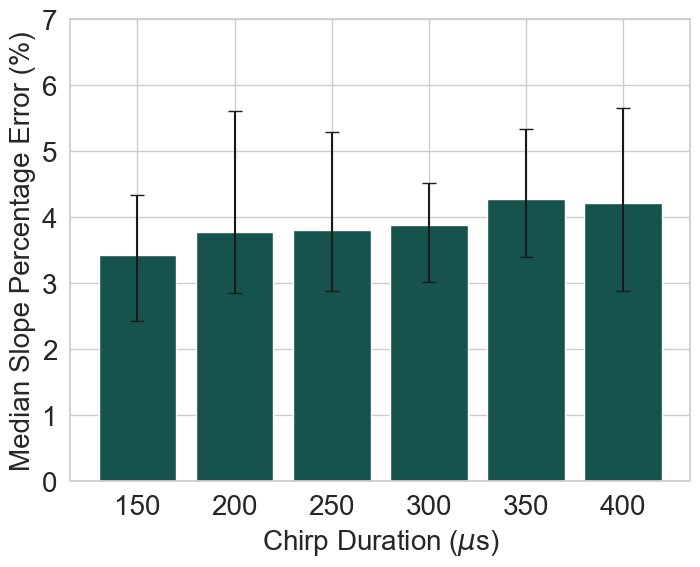

In [27]:
# Create a DataFrame for easier manipulation
data = pd.DataFrame({'Ground Truth': gt_slopes, 'Predicted': predicted_slopes})
# Calculate the absolute error
data['Error'] = np.abs(data['Predicted'] - data['Ground Truth'])
# Calculate the percentage error
data['Percentage Error'] = (data['Error'] / data['Ground Truth']) * 100

# Group by unique ground truth slope values to calculate percentage error distribution
grouped_percentage_error = data.groupby('Ground Truth')['Percentage Error'].apply(list)

# Prepare data for the box plot of percentage errors
boxplot_percentage_error_data = [grouped_percentage_error[key] for key in grouped_percentage_error.keys()]
percentage_error_labels = [f'GT: {key}' for key in grouped_percentage_error.keys()]

import ast
import seaborn as sns
import matplotlib

color_map = sns.color_palette("cubehelix", 3).as_hex()

hatch_map = ['', '/', '//']

# Set seaborn style
sns.set(style="whitegrid")

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fontsize = 20

# Calculate median, Q1, and Q3 values for each environment category
median_values = [np.median(grouped_percentage_error[key]) for key in grouped_percentage_error.keys()]
q1_values = [np.percentile(grouped_percentage_error[key], 25) for key in grouped_percentage_error.keys()]
q3_values = [np.percentile(grouped_percentage_error[key], 75) for key in grouped_percentage_error.keys()]

# Convert labels to a list
labels = ['150', '200', '250', '300', '350', '400']
# labels = [label + " $\mu$s" for label in labels]

# Calculate error bars (distance from median to Q1 and Q3)
lower_error = [median - q1 for median, q1 in zip(median_values, q1_values)]
upper_error = [q3 - median for median, q3 in zip(median_values, q3_values)]
errors = [lower_error, upper_error]

# Debugging print statements
print("Mean values:", median_values)
print("Q1 values:", q1_values)
print("Q3 values:", q3_values)
print("Lower error:", lower_error)
print("Upper error:", upper_error)

fontsize = 20
# Create the bar plot with error bars
plt.figure(figsize=(8, 6))  # Set figure size
plt.bar(labels, median_values, yerr=errors, capsize=5, color=color_map[0], hatch = hatch_map[0])  # Use yerr for error bars
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(0, 7)  # Set y-axis limits
# Set the title and labels
# plt.title('Bar Plot of Mean Slope Percentage Error with Q1-Q3 Error Bars')
plt.ylabel('Median Slope Percentage Error (%)', fontsize=fontsize)
plt.xlabel('Chirp Duration ($\mu$s)', fontsize=fontsize)
# Show the plot
plt.show()